## Auto Annotation Using Grounding Dino

In [1]:
!nvidia-smi

Wed Apr  3 17:34:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install Grounding DINO & additional dependencies

In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q roboflow dataclasses-json onemetric

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 430, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 430 (delta 149), reused 130 (delta 126), pack-reused 232
Receiving objects: 100% (430/430), 12.86 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (221/221), done.
/content/GroundingDINO
Branch 'feature/more_compact_inference_api' set up to track remote branch 'feature/more_compact_inference_api' from 'origin'.
Switched to a new branch 'feature/more_compact_inference_api'
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 69.2 MB/s

In [4]:
!pip install supervision

In [5]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
roboflow: 1.1.26 ; supervision: 0.4.0


**NOTE:** To run the Grounding DINO model we will need two things: a configuration file and a weights file. The first one is part of the repository we just cloned. The second one we need to download.

In [6]:
# confirm that configuration file exist

import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [7]:
# download weights file

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [8]:
# confirm that weights file exist

import os

WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


## Download  Data
Now let's use our dataset - feature engineering and automated data annotation.


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:

import zipfile

# Path to the zip file
zip_file_path = "/content/drive/MyDrive/DL/eyes_on_eats/initial_data_annotated.zip"

# Directory to extract the contents of the zip file
extract_dir = "/content/data"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")


Extraction complete.


## Load model

In [11]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/content/GroundingDINO


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)


final text_encoder_type: bert-base-uncased



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Model Prompt Engineering Results

Let's compare the prediction results we can get by running the Grounding DINO model in different modes, and what effect feature engineering has on the quality of the obtained results

In [12]:
SOURCE_IMAGE_PATH = f"{HOME}/data/initial_data/almonds/Image_1.jpg"
CLASSES = ['almond']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

### Caption Inference Mode
---
**NOTE:** Most flexible. You pass single prompt string as argument. Phrases returned by the model during prediction are treated as arbitrary strings and not as categories. For this reason, BoxAnnotator produces paint boxes in different colors even if the phrase assigned to the box is the same.

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


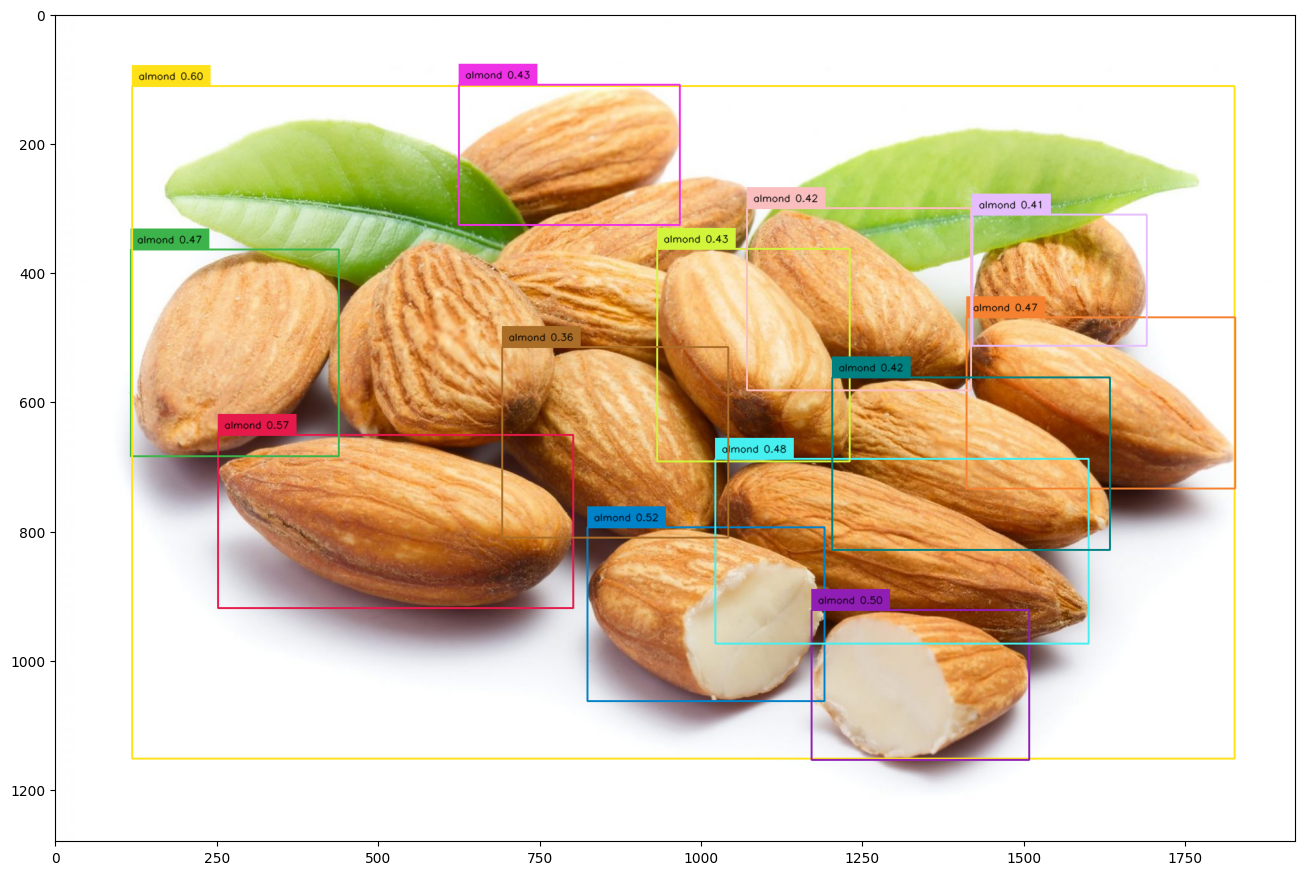

In [13]:
import cv2

import supervision as sv


image = cv2.imread(SOURCE_IMAGE_PATH)
caption = ", ".join(CLASSES)

detections, labels = model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{label} {confidence:0.2f}"
    for label, (_, confidence, class_id, _)
    in zip(labels, detections)]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

### Classes Inference Mode
---
**NOTE:** You pass list of classes as a argument. Phrases returned by the model during prediction are treated as categories. For this reason, BoxAnnotator produces paint boxes with the same associated categories with the same color.

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


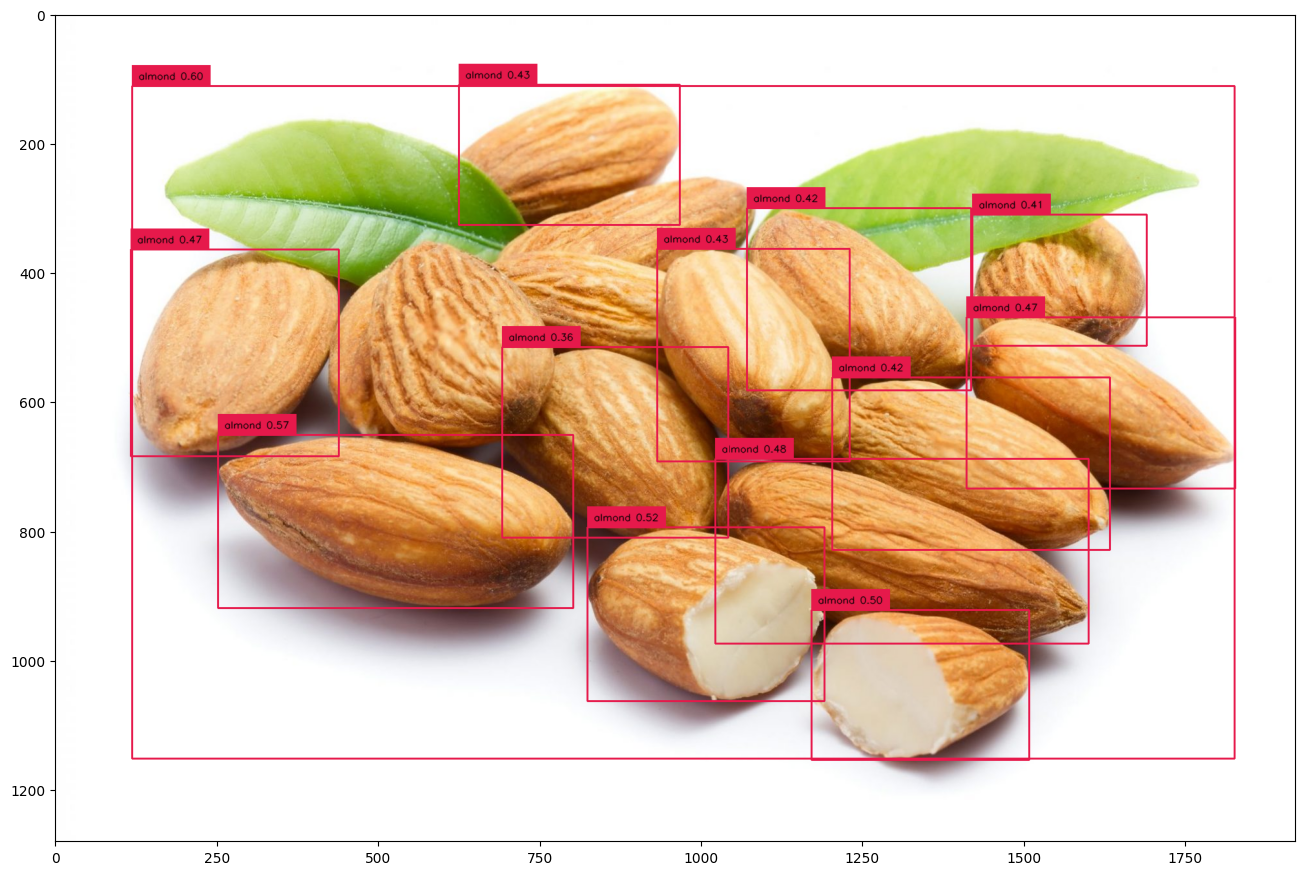

In [14]:
import cv2

import supervision as sv


image = cv2.imread(SOURCE_IMAGE_PATH)

detections = model.predict_with_classes(
    image=image,
    classes=CLASSES,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

### Enhanced Classes Inference Mode
---
**NOTE:** You pass list of classes as a argument. Those classes are enhenced using prompt engineering to ensure better result. Phrases returned by the model during prediction are treated as categories. For this reason, BoxAnnotator produces paint boxes with the same associated categories with the same color.

In [15]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

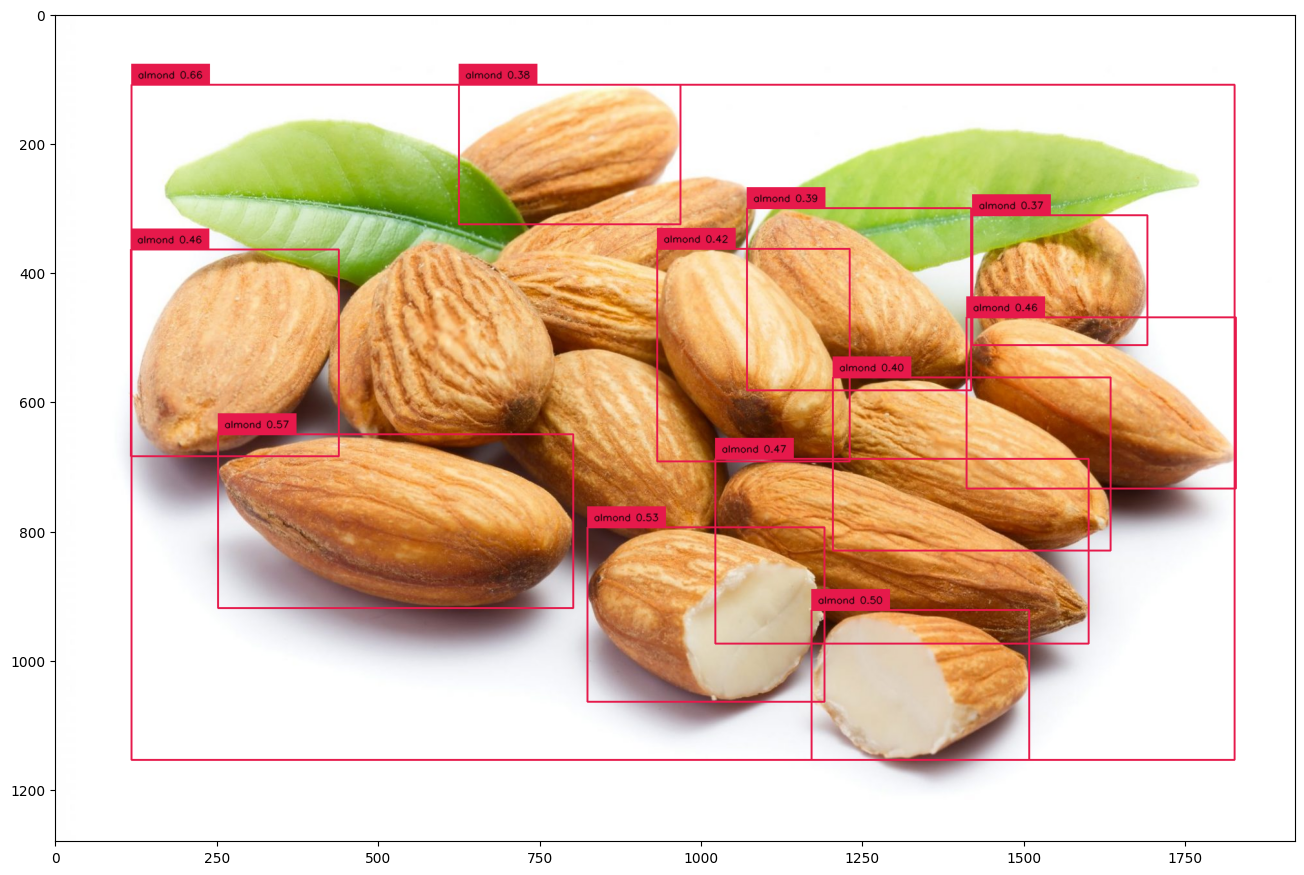

In [16]:
import cv2

import supervision as sv


image = cv2.imread(SOURCE_IMAGE_PATH)

detections = model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

**NOTE:** We can see that the quality of detection has improved. In particular, when it comes to the `chair` class.

## Time to annotate and save in PASCAL Visual Object Classes

In [17]:
import os
import cv2
import xml.etree.ElementTree as ET
from groundingdino.util.inference import Model
from tqdm import tqdm

# Define the home directory and the path to the dataset
HOME = "/content"
DATASET_DIR = os.path.join(HOME, "data", "initial_data")

# Load the Grounding DINO model
MODEL_CONFIG_PATH = os.path.join(HOME, "GroundingDINO", "groundingdino", "config", "GroundingDINO_SwinT_OGC.py")
WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
model = Model(model_config_path=MODEL_CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

# Load class labels from the file
LABELS_FILE_PATH = "/content/Final_classes.txt"
with open(LABELS_FILE_PATH, "r") as f:
    CLASSES = [line.strip() for line in f.readlines()]

# Define annotation thresholds
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

# Function to enhance class names
def enhance_class_name(class_names):
    return [f"all {class_name}s" for class_name in class_names]

# Function to create Pascal VOC format XML annotation
def create_pascal_voc_xml(image_filename, image_shape, boxes, labels):
    annotation = ET.Element("annotation")

    folder = ET.SubElement(annotation, "folder")
    folder.text = "ingredient_annotations"  # Folder name for annotations

    filename = ET.SubElement(annotation, "filename")
    filename.text = image_filename

    source = ET.SubElement(annotation, "source")
    database = ET.SubElement(source, "database")
    database.text = "Unknown"

    size = ET.SubElement(annotation, "size")
    width = ET.SubElement(size, "width")
    height = ET.SubElement(size, "height")
    depth = ET.SubElement(size, "depth")

    width.text = str(image_shape[1])
    height.text = str(image_shape[0])
    depth.text = str(image_shape[2])

    segmented = ET.SubElement(annotation, "segmented")
    segmented.text = "0"

    for box, label in zip(boxes, labels):
        object = ET.SubElement(annotation, "object")
        name = ET.SubElement(object, "name")
        pose = ET.SubElement(object, "pose")
        truncated = ET.SubElement(object, "truncated")
        difficult = ET.SubElement(object, "difficult")
        bndbox = ET.SubElement(object, "bndbox")
        xmin = ET.SubElement(bndbox, "xmin")
        ymin = ET.SubElement(bndbox, "ymin")
        xmax = ET.SubElement(bndbox, "xmax")
        ymax = ET.SubElement(bndbox, "ymax")

        name.text = label
        pose.text = "Unspecified"
        truncated.text = "0"
        difficult.text = "0"
        xmin.text = str(int(box[0]))
        ymin.text = str(int(box[1]))
        xmax.text = str(int(box[2]))
        ymax.text = str(int(box[3]))

    # Format the XML for better readability
    xml_string = ET.tostring(annotation, encoding="unicode")

    return xml_string

# Function to annotate images in a directory and save annotated images in Pascal VOC format
def annotate_images_in_directory(directory):
    for class_name in CLASSES:
        class_dir = os.path.join(directory, class_name)
        annotated_dir = os.path.join(directory, f"{class_name}_annotated")
        os.makedirs(annotated_dir, exist_ok=True)

        print("Processing images in directory:", class_dir)
        if os.path.isdir(class_dir):
            for image_name in tqdm(os.listdir(class_dir)):
                image_path = os.path.join(class_dir, image_name)
                image = cv2.imread(image_path)
                if image is None:
                    print("Failed to load image:", image_path)
                    continue

                detections = model.predict_with_classes(
                    image=image,
                    classes=enhance_class_name([class_name]),
                    box_threshold=BOX_THRESHOLD,
                    text_threshold=TEXT_THRESHOLD
                )
                # Drop potential detections with phrase not part of CLASSES set
                detections = detections[detections.class_id != None]
                # Drop potential detections with area close to area of the whole image
                detections = detections[(detections.area / (image.shape[0] * image.shape[1])) < 0.9]
                # Drop potential double detections
                detections = detections.with_nms()

                # Create the Pascal VOC XML annotation for this image
                xml_annotation = create_pascal_voc_xml(image_filename=image_name, image_shape=image.shape, boxes=detections.xyxy, labels=[class_name])

                # Save the Pascal VOC XML annotation to a file
                xml_filename = os.path.join(annotated_dir, f"{os.path.splitext(image_name)[0]}.xml")
                with open(xml_filename, "w") as xml_file:
                    xml_file.write(xml_annotation)

                # Save the annotated image
                annotated_image_path = os.path.join(annotated_dir, image_name)
                cv2.imwrite(annotated_image_path, image)

# Annotate images in the dataset directory
annotate_images_in_directory(DATASET_DIR)


final text_encoder_type: bert-base-uncased
Processing images in directory: /content/data/initial_data/all_purpose_flour


  2%|▏         | 1/50 [00:00<00:45,  1.07it/s]

Failed to load image: /content/data/initial_data/all_purpose_flour/Image_38.jpg


100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


Processing images in directory: /content/data/initial_data/almonds


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Processing images in directory: /content/data/initial_data/apple


 48%|████▊     | 24/50 [00:10<00:10,  2.40it/s]

Failed to load image: /content/data/initial_data/apple/Image_27.jpg


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


Processing images in directory: /content/data/initial_data/apricot


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Processing images in directory: /content/data/initial_data/asparagus


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Processing images in directory: /content/data/initial_data/avocado


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Processing images in directory: /content/data/initial_data/bacon


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Processing images in directory: /content/data/initial_data/banana


 44%|████▍     | 22/50 [00:11<00:14,  1.92it/s]

Failed to load image: /content/data/initial_data/banana/Image_2.jpg


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Processing images in directory: /content/data/initial_data/barley


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Processing images in directory: /content/data/initial_data/basil


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Processing images in directory: /content/data/initial_data/basmati_rice


100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Processing images in directory: /content/data/initial_data/beans


100%|██████████| 50/50 [00:29<00:00,  1.68it/s]


Processing images in directory: /content/data/initial_data/beef


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Processing images in directory: /content/data/initial_data/beets


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Processing images in directory: /content/data/initial_data/bell_pepper


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Processing images in directory: /content/data/initial_data/berries


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Processing images in directory: /content/data/initial_data/biscuits


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


Processing images in directory: /content/data/initial_data/blackberries


100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


Processing images in directory: /content/data/initial_data/black_pepper


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Processing images in directory: /content/data/initial_data/blueberries


100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


Processing images in directory: /content/data/initial_data/bread


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Processing images in directory: /content/data/initial_data/bread_crumbs


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Processing images in directory: /content/data/initial_data/bread_flour


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


Processing images in directory: /content/data/initial_data/broccoli


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Processing images in directory: /content/data/initial_data/brownie_mix


100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


Processing images in directory: /content/data/initial_data/brown_rice


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Processing images in directory: /content/data/initial_data/butter


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Processing images in directory: /content/data/initial_data/cabbage


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Processing images in directory: /content/data/initial_data/cake


100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


Processing images in directory: /content/data/initial_data/cardamom


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Processing images in directory: /content/data/initial_data/carrot


  8%|▊         | 4/50 [00:01<00:19,  2.32it/s]

Failed to load image: /content/data/initial_data/carrot/Image_42.jpg


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Processing images in directory: /content/data/initial_data/cashews


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


Processing images in directory: /content/data/initial_data/cauliflower


100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Processing images in directory: /content/data/initial_data/celery


100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Processing images in directory: /content/data/initial_data/cereal


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Processing images in directory: /content/data/initial_data/cheese


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


Processing images in directory: /content/data/initial_data/cherries


100%|██████████| 50/50 [00:31<00:00,  1.61it/s]


Processing images in directory: /content/data/initial_data/chicken


100%|██████████| 50/50 [00:27<00:00,  1.85it/s]


Processing images in directory: /content/data/initial_data/chickpeas


100%|██████████| 50/50 [00:27<00:00,  1.80it/s]


Processing images in directory: /content/data/initial_data/chocolate


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]


Processing images in directory: /content/data/initial_data/chocolate_chips


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Processing images in directory: /content/data/initial_data/chocolate_syrup


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Processing images in directory: /content/data/initial_data/cilantro


100%|██████████| 50/50 [00:26<00:00,  1.90it/s]


Processing images in directory: /content/data/initial_data/cinnamon


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Processing images in directory: /content/data/initial_data/clove


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Processing images in directory: /content/data/initial_data/cocoa_powder


100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


Processing images in directory: /content/data/initial_data/coconut


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Processing images in directory: /content/data/initial_data/cookies


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Processing images in directory: /content/data/initial_data/corn


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Processing images in directory: /content/data/initial_data/cucumber


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


Processing images in directory: /content/data/initial_data/dates


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Processing images in directory: /content/data/initial_data/eggplant


100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


Processing images in directory: /content/data/initial_data/eggs


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Processing images in directory: /content/data/initial_data/fish


100%|██████████| 50/50 [00:21<00:00,  2.38it/s]


Processing images in directory: /content/data/initial_data/garlic


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Processing images in directory: /content/data/initial_data/ginger


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


Processing images in directory: /content/data/initial_data/grapes


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Processing images in directory: /content/data/initial_data/honey


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Processing images in directory: /content/data/initial_data/jalapeno


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


Processing images in directory: /content/data/initial_data/kidney_beans


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


Processing images in directory: /content/data/initial_data/lemon


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Processing images in directory: /content/data/initial_data/mango


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Processing images in directory: /content/data/initial_data/marshmallows


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Processing images in directory: /content/data/initial_data/milk


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Processing images in directory: /content/data/initial_data/mint


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Processing images in directory: /content/data/initial_data/muffins


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Processing images in directory: /content/data/initial_data/mushroom


100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


Processing images in directory: /content/data/initial_data/noodles


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Processing images in directory: /content/data/initial_data/nuts


100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


Processing images in directory: /content/data/initial_data/oats


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]


Processing images in directory: /content/data/initial_data/okra


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Processing images in directory: /content/data/initial_data/olive


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Processing images in directory: /content/data/initial_data/onion


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Processing images in directory: /content/data/initial_data/orange


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Processing images in directory: /content/data/initial_data/oreo_cookies


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Processing images in directory: /content/data/initial_data/pasta


100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


Processing images in directory: /content/data/initial_data/pear


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Processing images in directory: /content/data/initial_data/pepper


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Processing images in directory: /content/data/initial_data/pineapple


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Processing images in directory: /content/data/initial_data/pistachios


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


Processing images in directory: /content/data/initial_data/pork


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


Processing images in directory: /content/data/initial_data/potato


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Processing images in directory: /content/data/initial_data/pumpkin


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


Processing images in directory: /content/data/initial_data/radishes


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Processing images in directory: /content/data/initial_data/raisins


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Processing images in directory: /content/data/initial_data/red_chilies


100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


Processing images in directory: /content/data/initial_data/rice


100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Processing images in directory: /content/data/initial_data/rosemary


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Processing images in directory: /content/data/initial_data/salmon


100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


Processing images in directory: /content/data/initial_data/salt


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


Processing images in directory: /content/data/initial_data/shrimp


100%|██████████| 50/50 [00:24<00:00,  2.00it/s]


Processing images in directory: /content/data/initial_data/spinach


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Processing images in directory: /content/data/initial_data/strawberries


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Processing images in directory: /content/data/initial_data/sugar


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Processing images in directory: /content/data/initial_data/sweet_potato


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


Processing images in directory: /content/data/initial_data/tomato


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]


Processing images in directory: /content/data/initial_data/vanilla_ice_cream


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


Processing images in directory: /content/data/initial_data/walnuts


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Processing images in directory: /content/data/initial_data/watermelon


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Processing images in directory: /content/data/initial_data/yogurt


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]


In [18]:
import os
import shutil

def remove_original_dirs(base_dir):
    all_dirs = os.listdir(base_dir)
    annotated_dirs = {d for d in all_dirs if d.endswith('_annotated')}
    original_dirs = {d.replace('_annotated', '') for d in annotated_dirs}

    # Identify and remove original directories if their annotated version exists
    for original_dir in original_dirs:
        if original_dir in all_dirs:  # Check if the original directory exists
            original_path = os.path.join(base_dir, original_dir)
            print(f"Removing original directory: {original_path}")
            shutil.rmtree(original_path)

# Specify the base directory
base_dir = '/content/data/initial_data'
remove_original_dirs(base_dir)

print("Original directories removal complete.")


Removing original directory: /content/data/initial_data/asparagus
Removing original directory: /content/data/initial_data/basil
Removing original directory: /content/data/initial_data/honey
Removing original directory: /content/data/initial_data/shrimp
Removing original directory: /content/data/initial_data/bread_flour
Removing original directory: /content/data/initial_data/apricot
Removing original directory: /content/data/initial_data/watermelon
Removing original directory: /content/data/initial_data/salmon
Removing original directory: /content/data/initial_data/potato
Removing original directory: /content/data/initial_data/sugar
Removing original directory: /content/data/initial_data/tomato
Removing original directory: /content/data/initial_data/onion
Removing original directory: /content/data/initial_data/brownie_mix
Removing original directory: /content/data/initial_data/vanilla_ice_cream
Removing original directory: /content/data/initial_data/chocolate_chips
Removing original dir

In [19]:
import shutil

# Define the directory to zip and the output zip file path
dir_to_zip = '/content/data/initial_data'
output_zip_path = '/content/initial_data_annotated.zip'

# Create a zip archive of the directory
shutil.make_archive(base_name=output_zip_path[:-4], format='zip', root_dir=dir_to_zip)

print(f"Directory {dir_to_zip} has been zipped as {output_zip_path}")


Directory /content/data/initial_data has been zipped as /content/initial_data_annotated.zip
